In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)

In [2]:
from decimal import *

In [29]:
# LCDM background
h              = Decimal(0.6737)
c              = Decimal(1)
G              = Decimal(1)
kappa          = Decimal(8)*Decimal(np.pi)*G
a_today        = Decimal(1)
Hprop_today    = (h*c)/Decimal(2997.9)
t_today_EdS    = Decimal(2)/(Decimal(3)*Hprop_today)
Omega_m_today  = Decimal(0.3147)
rho_flrw_today = (Decimal(3)*Omega_m_today*Hprop_today**Decimal(2))/kappa
Omega_l_today  = Decimal(1) - Omega_m_today
Lambda         = Omega_l_today*Decimal(3)*(Hprop_today**Decimal(2))/(c**Decimal(2))
def a(t):
    return a_today*(Omega_m_today/Omega_l_today)**(Decimal(1)/Decimal(3))*sinh(np.sqrt(Omega_l_today)*t/t_today_EdS)**(Decimal(2)/Decimal(3))
def dta(t):
    return Hprop(t)*a(t)
def dtdta(t):
    return dta(t)*Hprop(t)+a(t)*dtHprop(t)#((Lambda/3)-(kappa*rho_flrw(t)/6))
def at(tau):
    return a_today*(Omega_m_today/Omega_l_today)**(Decimal(1)/Decimal(3))*sinh(tau)**(Decimal(2)/Decimal(3))
def dtaua(tau):
    return (Decimal(2)/Decimal(3))*atau(tau)*cosh(tau)/sinh(tau)
def Hprop(t):
    return Hprop_today * np.sqrt( Omega_m_today/((a(t)/a_today)**Decimal(3)) + Omega_l_today )
def dtHprop(t):
    return -Decimal(3)*Omega_m_today*dta(t)*(a_today**Decimal(3))*(a(t)**(-Decimal(4)))*(Hprop_today**Decimal(2))/(Decimal(2)*Hprop(t))
def Omega_m(t):
    return Omega_m_today / ( Omega_m_today + Omega_l_today*((a(t)/a_today)**Decimal(3)) )
def rho_flrw(t):
    return rho_flrw_today/a(t)**Decimal(3)

In [38]:
'{:.30f}'.format(1000+1/3-1000)

'0.333333333333371228945907205343'

In [39]:
'{:.30f}'.format(1/3)

'0.333333333333333314829616256247'

In [36]:
'{:.30f}'.format(Decimal(1000)/Decimal(3000))

'0.333333333333333333333333333300'

In [31]:
allNs = list(np.arange(8, 150, 4))
meanerror_3R = []
meanerror_B2 = []
meanerror_BT = []
meanerror_E2 = []
meanerror_ET = []
meanerror_3Ri = []
meanerror_E2i = []
for N in allNs:
    L = Decimal(20)
    dx = L/N
    FD = FD_file.FD_Class(dx, periodic_boundary=False)
    xyz = np.arange(-L/Decimal(2), L/Decimal(2), dx)[:N]
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    Box_zero = np.array([np.array([np.array([Decimal(0) for ix in range(N)]) for iy in range(N)]) for iz in range(N)])
    Box_ones = np.array([np.array([np.array([Decimal(1) for ix in range(N)]) for iy in range(N)]) for iz in range(N)])
    loc = int(N/Decimal(2)), int(N/Decimal(2)), int(N/Decimal(2))
    
    t = Decimal(1.5)
    Amp = Decimal(1000)
    k = Decimal(2)*Decimal(np.pi)/L
    tauC = np.sqrt(Decimal(3)*Lambda/Decimal(4))
    betaP = Amp*(Decimal(1)-np.array([np.array([np.array([sin(z[ix, iy, iz]) for ix in range(N)]) for iy in range(N)]) for iz in range(N)]))
    dzbetaP = -k*Amp*np.array([np.array([np.array([cos(z[ix, iy, iz]) for ix in range(N)]) for iy in range(N)]) for iz in range(N)])
    betaM = Decimal(0)
    B = (Decimal(3)/Decimal(4))*(Hprop_today**Decimal(2))*(Omega_l_today*(Omega_m_today**Decimal(2)))**(Decimal(1)/Decimal(3))
    A = Decimal(1)+B*betaP*(x**Decimal(2)+y**Decimal(2))

    tau = tauC*t
    fM = cosh(tau)/sinh(tau)
    hyperthing = Decimal(sc.hyp2f1(5/6, 3/2, 11/6, -np.sinh(1.5*np.sqrt(9*(1 - 0.3147)*((0.6737/2997.9)**2)/4))**2))
    integrated_part = (Decimal(3)/Decimal(5))*np.sqrt(cosh(tau)**Decimal(2))*hyperthing*(sinh(tau)**(Decimal(5)/Decimal(3)))/cosh(tau)
    fP = fM*integrated_part
    dtaufM = -Decimal(1)/sinh(tau)**Decimal(2)
    dtfM = tauC*dtaufM
    part_to_integrate = (sinh(tau)**(Decimal(2)/Decimal(3)))/cosh(tau)**Decimal(2)
    dtaufP = dtaufM*integrated_part+fM*part_to_integrate
    dtfP = tauC*dtaufP
    dtaudtaufM = Decimal(2)*cosh(tau)/sinh(tau)**Decimal(3)
    dtdtfM = (tauC**Decimal(2))*dtaudtaufM
    dtau_part_to_integrate = (Decimal(Decimal(2))/Decimal(3))*(sinh(tau)**(-Decimal(1)/Decimal(3)))*(cosh(tau)**(-Decimal(1)))-Decimal(2)*(sinh(tau)**(Decimal(5)/Decimal(3)))*(cosh(tau)**(-Decimal(3)))
    dtaudtaufP = dtaudtaufM*integrated_part+Decimal(Decimal(2))*dtaufM*part_to_integrate+fM*dtau_part_to_integrate
    dtdtfP = (tauC**Decimal(Decimal(2)))*dtaudtaufP

    F     = betaM*fM + betaP*fP
    dzF   = dzbetaP*fP
    Z     = F + A
    dxZ   = Decimal(2)*B*betaP*x
    dxdxZ = Decimal(2)*B*betaP
    dyZ   = Decimal(2)*B*betaP*y
    dydyZ = Decimal(2)*B*betaP
    dzZ   = dzF + B*dzbetaP*(x**Decimal(2)+y**Decimal(2))
    dtZ   = betaM*dtfM + betaP*dtfP
    dtdtZ = betaM*dtdtfM + betaP*dtdtfP

    delta =  -F/Z
    rho =  rho_flrw(t)*(Decimal(1)+delta)

    gdown = (a(t)**Decimal(2))*np.array([[Box_ones, Box_zero, Box_zero],
                                [Box_zero, Box_ones, Box_zero],
                                [Box_zero, Box_zero, Z**Decimal(2)]])
    gdown4 = np.array([[-Box_ones, Box_zero, Box_zero, Box_zero],
                       [Box_zero, gdown[0,0], gdown[0,1], gdown[0,2]],
                       [Box_zero, gdown[1,0], gdown[1,1], gdown[1,2]],
                       [Box_zero, gdown[2,0], gdown[2,1], gdown[2,2]]])
    nup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])

    Kdown = -(a(t)**Decimal(2))*np.array([[Box_ones*Hprop(t), Box_zero,          Box_zero],
                                 [Box_zero,          Box_ones*Hprop(t), Box_zero],
                                 [Box_zero,          Box_zero,          (Z**Decimal(2))*(Hprop(t)+dtZ/Z)]])
    
    glist = [gdown[0,0], gdown[0,1], gdown[0,2], gdown[1,1], gdown[1,2], gdown[2,2]]
    gdet = RRead.det(glist)
    gup = RRead.inv(glist, gdet)
    RCW = RCW_file.Ricci_CoGrad_Weyl_Class(dx, periodic_boundary=False)
    Gudd = RCW.Christoffel_symbol(gdown, gup)
    RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)
    
    RicciS3th = -Decimal(2)*(dxdxZ+dydyZ)/(a(t)*a(t)*Z)
    meanerror_3R += [np.mean(np.ma.masked_invalid(abs(RicciS3/RicciS3th-Decimal(1))))]
    meanerror_3Ri += [abs(RicciS3[loc]/RicciS3th[loc]-Decimal(1))]
    
    
    udown = np.array([-Box_ones, Box_zero, Box_zero, Box_zero])
    Tdown4 = rho*np.einsum('a...,b...->ab...',udown,udown)
    Bdict = RCW.Weyl_B(gdown4, nup, gdown, gup, Gudd, Kdown)
    meanerror_B2 += [np.mean(np.ma.masked_invalid(abs(Bdict['B2'])))]
    meanerror_BT += [np.mean(np.ma.masked_invalid(abs(Bdict['Btrace'])))]
    
    Edict = RCW.Weyl_E(gdown, gup, RicciS3, RicciTdown, Kdown, kappa, rho, Lambda, Tdown4[1:,1:])
    E2th = ((dydyZ**Decimal(2))-dxdxZ*dydyZ+(dxdxZ**Decimal(2))+(a(t)**Decimal(2))*((dta(t)*dtZ+a(t)*dtdtZ)**Decimal(2))+a(t)*(dxdxZ+dydyZ)*(dta(t)*dtZ+a(t)*dtdtZ))/(Decimal(6)*(a(t)**Decimal(4))*(Z**Decimal(2)))
    meanerror_E2 += [np.mean(np.ma.masked_invalid(abs(Edict['E2']/E2th-1)))]
    meanerror_E2i += [abs(Edict['E2'][loc]/E2th[loc]-Decimal(1))]
    meanerror_ET += [np.mean(np.ma.masked_invalid(abs(Edict['Etrace'])))]
    del Edict
    print('N={}, error={:.2e}, {:.2e} | {:.2e}, {:.2e} | {:.2e}, {:.2e} | {:.2e}'.format(N, meanerror_3R[-1], meanerror_3Ri[-1], meanerror_B2[-1], meanerror_BT[-1], meanerror_E2[-1], meanerror_E2i[-1], meanerror_ET[-1]))
    

TypeError: invalid data type for einsum

In [24]:
def exp(x):
    """Return e raised to the power of x.  Result type matches input type.

    >>> print(exp(Decimal(1)))
    2.718281828459045235360287471
    >>> print(exp(Decimal(2)))
    7.389056098930650227230427461
    >>> print(exp(2.0))
    7.38905609893
    >>> print(exp(2+0j))
    (7.38905609893+0j)

    """
    getcontext().prec += 2
    i, lasts, s, fact, num = 0, 0, 1, 1, 1
    while s != lasts:
        lasts = s
        i += 1
        fact *= i
        num *= x
        s += num / fact
    getcontext().prec -= 2
    return +s

def cosh(x):
    return (exp(x) + exp(-x))/Decimal(2)
def sinh(x):
    return (exp(x) - exp(-x))/Decimal(2)

def sin(x):
    """Return the sine of x as measured in radians.

    The Taylor series approximation works best for a small value of x.
    For larger values, first compute x = x % (2 * pi).

    >>> print(sin(Decimal('0.5')))
    0.4794255386042030002732879352
    >>> print(sin(0.5))
    0.479425538604
    >>> print(sin(0.5+0j))
    (0.479425538604+0j)

    """
    getcontext().prec += 2
    i, lasts, s, fact, num, sign = 1, 0, x, 1, x, 1
    while s != lasts:
        lasts = s
        i += 2
        fact *= i * (i-1)
        num *= x * x
        sign *= -1
        s += num / fact * sign
    getcontext().prec -= 2
    return +s

def cos(x):
    """Return the cosine of x as measured in radians.

    The Taylor series approximation works best for a small value of x.
    For larger values, first compute x = x % (2 * pi).

    >>> print(cos(Decimal('0.5')))
    0.8775825618903727161162815826
    >>> print(cos(0.5))
    0.87758256189
    >>> print(cos(0.5+0j))
    (0.87758256189+0j)

    """
    getcontext().prec += 2
    i, lasts, s, fact, num, sign = 0, 0, 1, 1, 1, 1
    while s != lasts:
        lasts = s
        i += 2
        fact *= i * (i-1)
        num *= x * x
        sign *= -1
        s += num / fact * sign
    getcontext().prec -= 2
    return +s

<IPython.core.display.Javascript object>


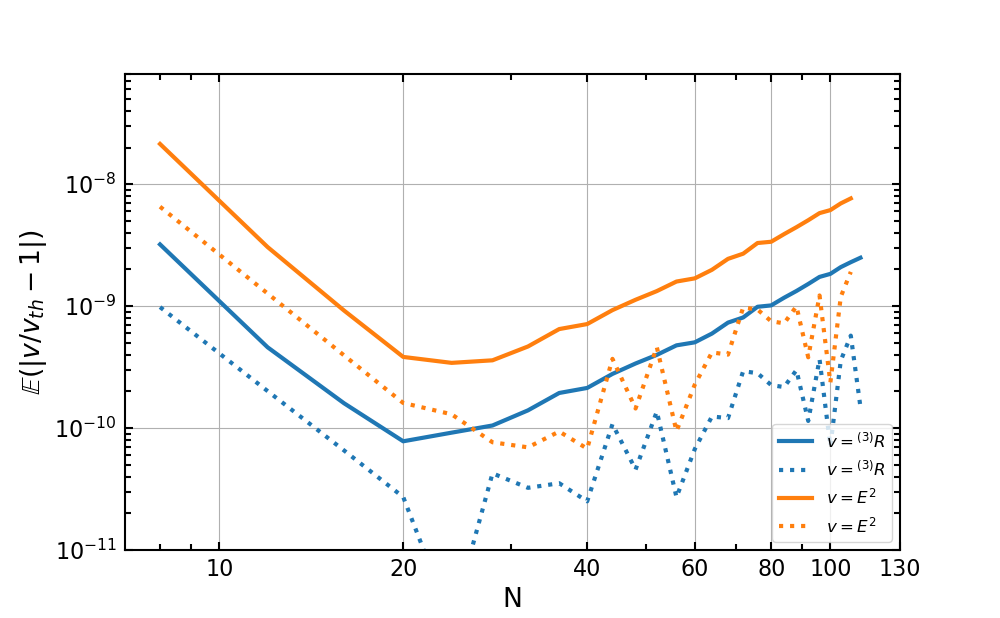

(1e-11, 8e-08)

In [10]:
idec = 0
iinc = -1


phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
plt.loglog(allNs[:len(meanerror_3R)], meanerror_3R, label=r'$v={}^{(3)}R$')
plt.loglog(allNs[:len(meanerror_3Ri)], meanerror_3Ri, 'C0:', label=r'$v={}^{(3)}R$')
#yplot_4th_order_decrease = [meanerror_3R[idec]*((allNs[idec]/N)**4) for N in allNs]
#yplot_4th_order_increase = [meanerror_3R[iinc]*((N/allNs[iinc])**2.5) for N in allNs]
#plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2)
#plt.loglog(allNs, yplot_4th_order_increase, 'C3--', linewidth=2)

plt.loglog(allNs[:len(meanerror_E2)], meanerror_E2, 'C1', label=r'$v=E^2$')
plt.loglog(allNs[:len(meanerror_E2i)], meanerror_E2i, 'C1:', label=r'$v=E^2$')
#yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**4) for N in allNs]
#yplot_4th_order_increase = [meanerror_E2[iinc]*((N/allNs[iinc])**2.5) for N in allNs]
#plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2, label='Truncation error') #4th order increase
#plt.loglog(allNs, yplot_4th_order_increase, 'C3--', linewidth=2, label='Rounding error')   #2.75 order increase


#plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
#yplot_4th_order_decrease = [meanerror_B2[idec]*((allNs[idec]/N)**4) for N in allNs]
#plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2, label='Truncation error')

plt.legend(loc=4, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.xticks([10,20,40,60,80,100,130], ['10','20','40','60','80','100','130'])
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')
plt.ylim(1e-11, 8e-8)
#plt.savefig('Plots/Szekeres_Slicing.pdf')

In [15]:
import pandas as pd
data = np.array([allNs, meanerror_3R, meanerror_B2, meanerror_BT, meanerror_E2, meanerror_ET]).T
columns = ['N', '3R', 'B2', 'BT', 'E2', 'ET']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/Szekeres_Slicing.csv')